In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# my imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 100)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import missingno as msno

In [28]:
msno.__version__

'0.5.2'

In [29]:
train = pd.read_csv("./kaggle/input/house-prices-advanced-regression-techniques/train.csv") #altered paths from original notebook to work with my file structure
test = pd.read_csv("./kaggle/input/house-prices-advanced-regression-techniques/test.csv")    

def get_info(df: pd.DataFrame):
    dtypes = df.dtypes.to_frame('Data Type') #a pandas column is a series, we need it saved as a dataframe so we can customise the info output
    non_null = df.count().to_frame('Non-Null Count') #anything less than 1460 is a NA value
    unique_values = df.nunique().to_frame('Unique Count')
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    min_value1 = df[numeric_cols].min().to_frame('Min Value')
    max_value1 = df[numeric_cols].max().to_frame('Max Value')
    info = pd.concat([dtypes, non_null, unique_values, min_value1, max_value1], axis=1) # Consolidate    
    # Sorting the output is the whole reason i made this function
    info = info.sort_values(['Data Type', info.columns[0]])
    return info

print(train.shape)
#get_info(train) #large output

(1460, 81)


## EDA & Feature Engineering

**Id**  is useless as a feature and we can safely drop it. We also have to drop the SalePrice but i will keep it for now for factor analysis.

In [30]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

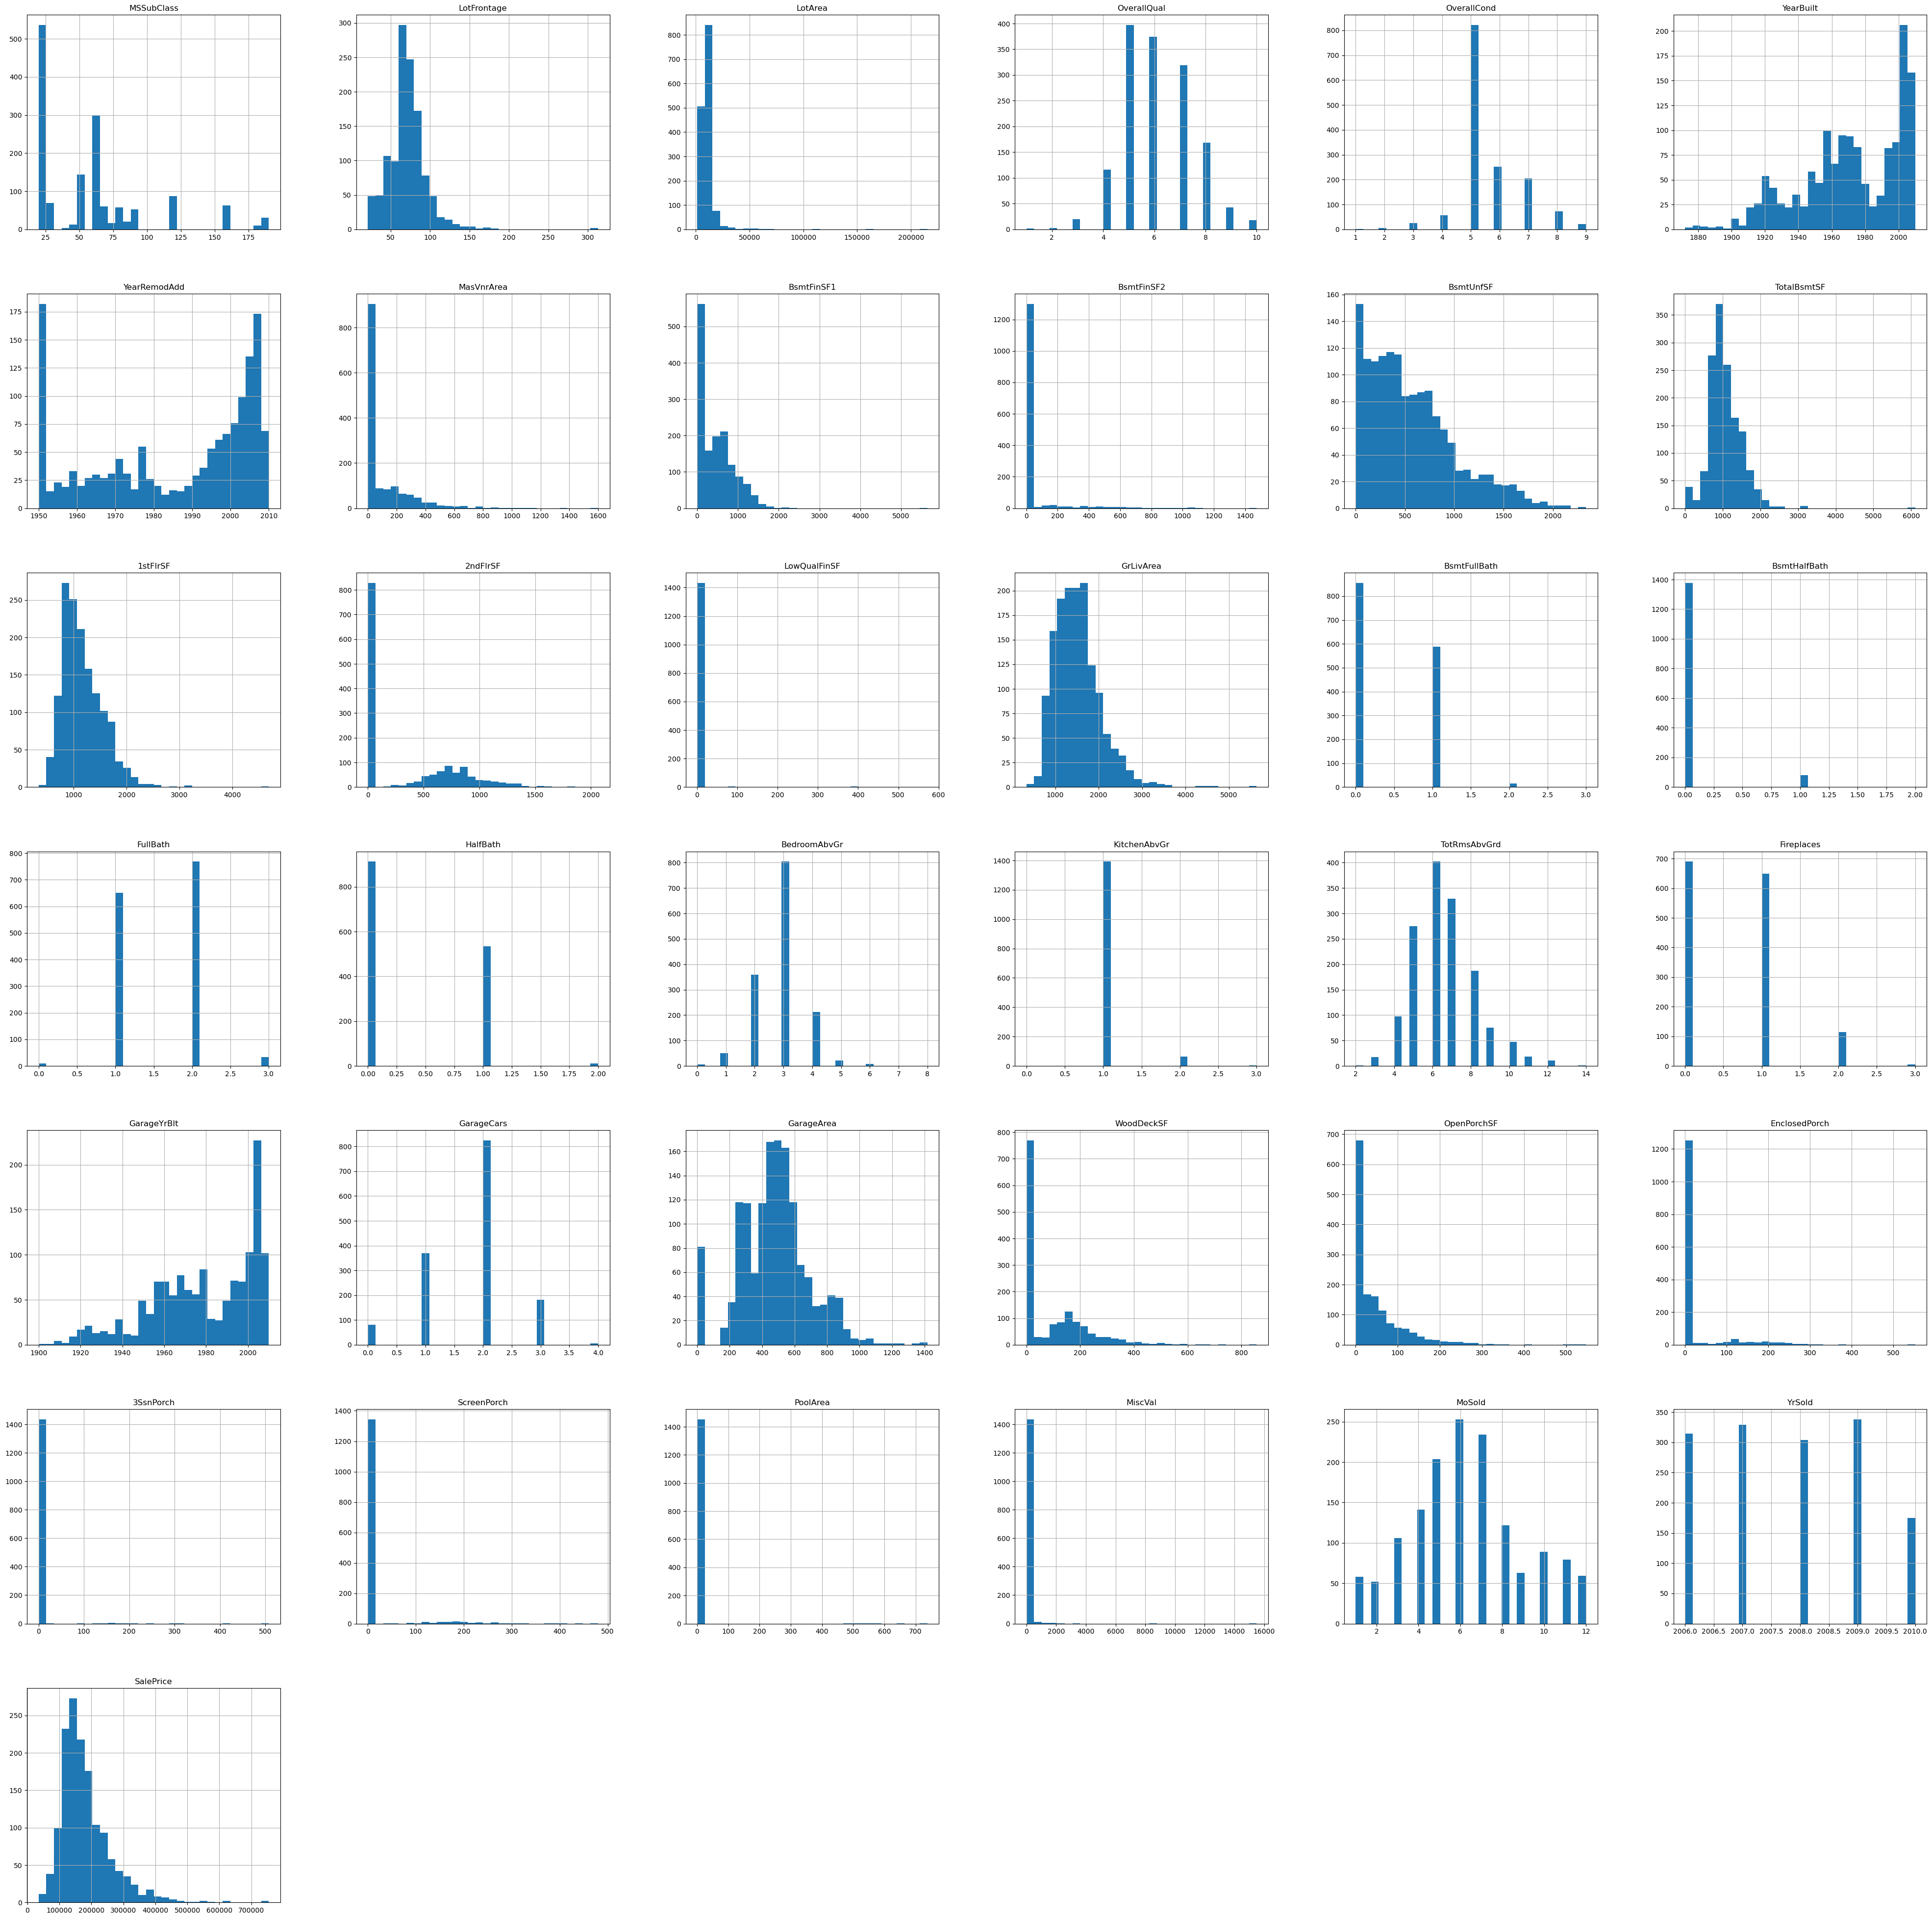

In [31]:
ax = train.hist(bins=30, figsize=(50, 50))  #inspecting the distributions to get ideas on handling NAs/Outliers
plt.show()

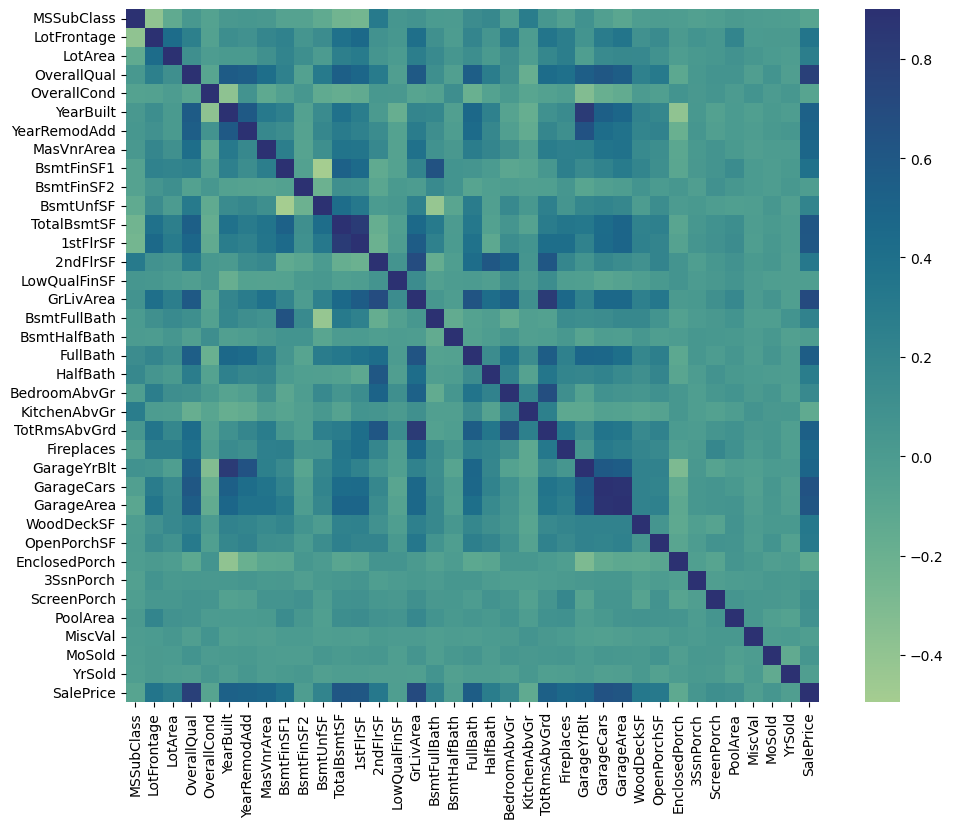

In [32]:
df_num = train.select_dtypes(include = ['float64','int64'])
#df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); #numeric historgram
# #correlation matrix
corrmat = df_num.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True,cmap="crest");


In [33]:
corrmat["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

The top 5 features need special attention. Going back to the distribution plots above now that we know how important GrLivArea is (2nd most important factor according to our matrix) it would be best to get rid of outliers.


In [34]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

Lets see our missing values.

<AxesSubplot:>

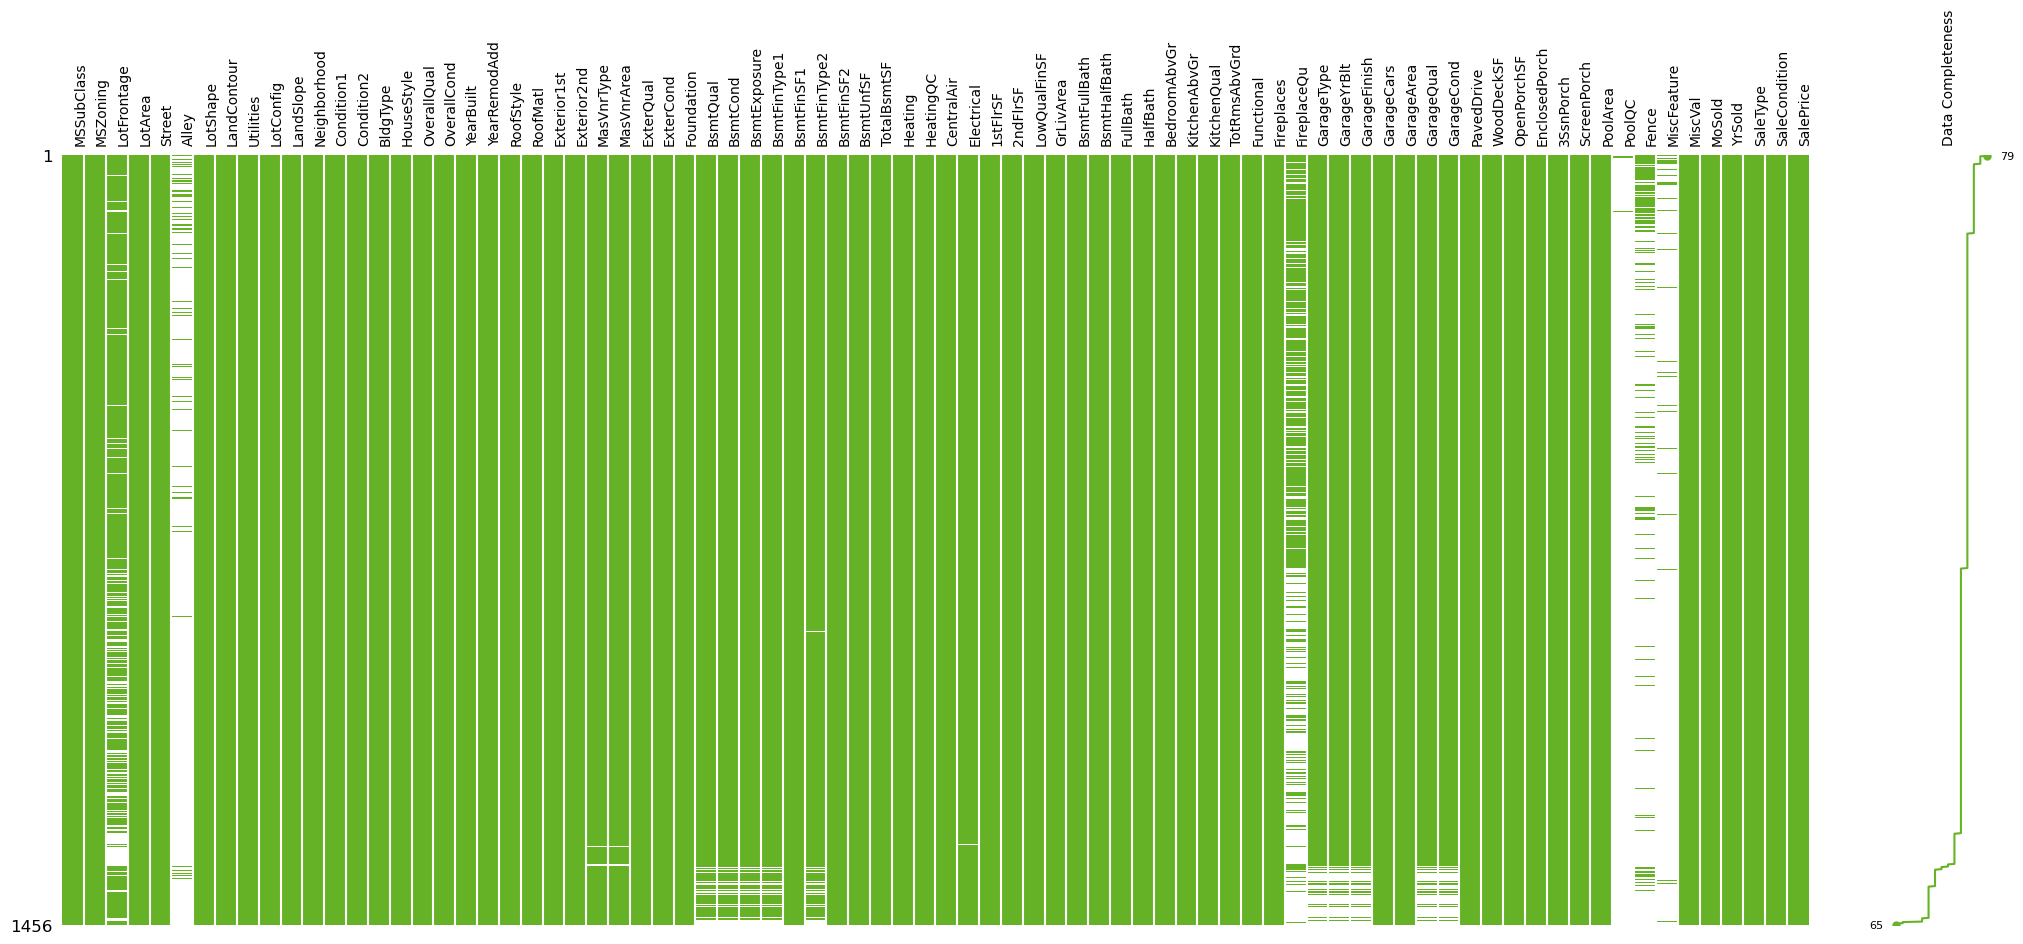

In [35]:
msno.matrix(train, sort="descending", figsize=(25, 10), width_ratios=(15, 1), color=(0.4, 0.7, 0.15), fontsize=10, labels=True, label_rotation=90, sparkline=True)

Looks like we are also gonna have to handle lots of missing values. Consulting the provided data description pdf shows that many "NAs" can be explained.


I use this part of the notebook for inspecting information about our attributes.

In [36]:
#for i in train.columns:
#    count = train[i].nunique() 
#    print('Count of unique', i, 'is:', count)

In [37]:
#unique_values = train['PoolQC'].unique()
#unique_values = train['Street'].unique()
#print(train['Street'].value_counts())
#print(train['PoolQC'].value_counts())
#unique_values = train['Utilities'].unique()
#print(train['Utilities'].value_counts())
unique_values = train['PoolArea'].unique();print(unique_values) #
print(train['PoolArea'].value_counts())

[  0 512 648 576 519 738]
0      1451
512       1
648       1
576       1
519       1
738       1
Name: PoolArea, dtype: int64


In [38]:
print(train['Exterior2nd'].describe())
#print(train['BsmtQual'].describe())

count        1456
unique         16
top       VinylSd
freq          504
Name: Exterior2nd, dtype: object


<AxesSubplot:>

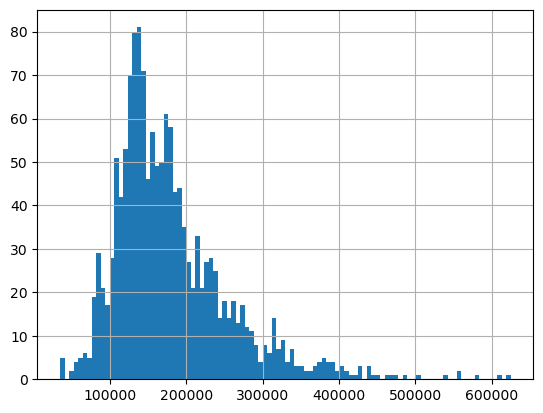

In [39]:
train['SalePrice'].hist(bins=100) #sale price is skewed


*log1p* will normalise our target as it has a left skew and is also a necessary transformation for our evaluation metric once we build our models (MSLE - Mean Squared Logarithmic Error). 

At the time of evaluation, when we submit our model and check its performance on the leaderboard, we will have to use the inverse of log1p, *expm1* to transform the entries back to normal pricing values.

In [40]:
train["SalePrice"] = np.log1p(train["SalePrice"]) 

Its time to start proper feature engineering. 
I will save the target of the train data as *y* then concatenate the train and 

In [41]:
y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(2915, 79)

We are gonna start with recastings and then imputations.

In [42]:
#Recasting these as strings instead of numbers
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
#dropping these 
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [43]:
#mode imputes
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features['Functional'] = features['Functional'].fillna(features['Functional'].mode()[0]) 
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

In [44]:
#Zero, and None imputes
for col in (['GarageYrBlt', 'GarageArea', 'GarageCars']):
    features[col] = features[col].fillna(0)
    
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

In [45]:
#Imputing MS zoning based on the MSSubclass 
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#Imputing LotFrontage based on Neighborhood
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#Imputing None to objects
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

#Imputing 0 to numerics
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

With these features we want to emphasize, their existance (of a basement,pool, etc), in addition to their dimensions.
By the end will will onehot encode every categorical variable and finalise our features before training.

In [46]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
#feature matrix projection
final_features = pd.get_dummies(features).reset_index(drop=True)

We will split the features in two, the first part will select the rows of the training set according to the length of y, and the rest will be the test set. 

In [47]:
X = final_features.iloc[:len(y), :]	
X_sub = final_features.iloc[len(y):, :]

## Training

The most commonly used strategy is to blend regressors and average their results. 

In [48]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from datetime import datetime

Here we will define are cross validation strategy (5 folds), the evaluation metric (RMSLE) for the models and for their folds (cv_rmse) and the models themselves.
XGBoostRegressor would be the first candidate but since we are stacking, we will also add its slightly less regularized brother, GradientBoostingRegressor and also Ridge and Lasso regressors, as their are strong regularisers and can help prevent overfitting as well as elasticnet which is kind of a combination of the two and combine everything in the StackingRegressors.
Since we will be crossvalidating every model, we will use their CV counterparts.

This is the most computationally demanding part of the analysis, as we have an infinite amount of values to optimise. I will be using some defaults and values other people have had success with.
The most obvious ones are the strength of the regularisation (L1,L2) for lasso ,ridge, elasticnet which is their alpha value. Elasticnet uses a ratio of the two called l1_ratio. 

The boosters can optimise their learning_rate, number of estimators, max depth of each etc~.
XGBoost will be also the model that will be taking the votes of every other model at the end.

I will be printing out the score of each model, in order to assign a weight to its performance when its time to blend the models.

In [49]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(random_state=42, cv=kfolds))
elasticnet= make_pipeline(RobustScaler(), ElasticNetCV(cv=kfolds, l1_ratio=e_l1ratio))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =42)
#i am gonna double the estimators i used in a previous run and also double the max_depth
#also gonna try higher learning rate
xgboost = XGBRegressor(learning_rate=0.05, n_estimators=7200,
                                     max_depth=6, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.2,
                                     objective='reg:squarederror', nthread=-1, #reg:linear is deprecated
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost,),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),datetime.now(),)
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),datetime.now(),)
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),datetime.now(),)
score = cv_rmse(lasso)
print("lasso:: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(elasticnet)
print("elasticnet:: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


ridge_model_full_data = ridge.fit(X, y)
gbr_model_full_data = gbr.fit(X, y)
xgb_model_full_data = xgboost.fit(X, y)
lasso_model_full_data = lasso.fit(X, y)
elasticnet_model_full_data = elasticnet.fit(X,y)
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

Ridge: 0.1156 (0.0085)
 2023-10-08 17:45:39.683182
gbr: 0.1167 (0.0108)
 2023-10-08 17:46:37.446182
xgboost: 0.1183 (0.0104)
 2023-10-08 17:47:28.511073
lasso:: 0.1257 (0.0083)
 2023-10-08 17:47:29.870214
elasticnet:: 0.1257 (0.0083)
 2023-10-08 17:47:35.936391


In [50]:
def blend_models_predict(X):
    return ((0.2 * ridge_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * elasticnet_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.4 * stack_gen_model.predict(np.array(X))))

print(rmsle(y, blend_models_predict(X)))

0.04754122314654324


A performance score of 0.04 is pretty much perfect but only guarantees a top 200 finish in the competition. It's unfortunate that the leaderboard is poisoned with chaeting entries but overall this was a great learning journey.

The performance score is a far cry from productionized models trained on real life data but at the end of the day this is a proof of concept competition.

Commented out kaggle code.

In [51]:
#submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
#submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))
#submission.to_csv("submission.csv", index=False)